## daart training example
This notebook demonstrates how to create a daart model (as well as the data generator), train the model on some example data provided in the repo, then assess model performance.

The python script located at `daart/examples/fit_models.py` generalizes these steps and allows users to fit multiple models from the command line more easily. The script utilizes yaml configuration files to set hyperparameters; examples can be found in the directory `daart/data/configs`.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

from daart.data import DataGenerator, compute_sequence_pad
from daart.eval import get_precision_recall, plot_training_curves
from daart.models import Segmenter
from daart.train import Trainer
from daart.transforms import ZScore

### define data paths

In [2]:
# choose one experiment for training
expt_id = '2019_06_26_fly2'

# where data is stored
base_dir = os.path.join(os.path.dirname(os.getcwd()), 'data')

# where model results will be saved
model_save_path = os.path.join(os.path.dirname(os.getcwd()), 'results')

# DLC markers
markers_file = os.path.join(base_dir, 'markers', expt_id + '_labeled.h5')
# heuristic labels
labels_file = os.path.join(base_dir, 'labels-heuristic', expt_id + '_labels.csv')
# hand labels
hand_labels_file = os.path.join(base_dir, 'labels-hand', expt_id + '_labels.csv')

### build data generator

In [3]:
# define data generator signals
signals = ['markers', 'labels_weak', 'labels_strong']
transforms = [ZScore(), None, None]
paths = [markers_file, labels_file, hand_labels_file]

device = 'cpu'  # 'cpu' | 'cuda'
sequence_pad = 16  # add `sequence_pad` data points on either side of sequence for convolutions

trial_splits = {
    'train_tr': 9,
    'val_tr': 1,
    'test_tr': 0,
    'gap_tr': 0
}

# build data generator
data_gen = DataGenerator(
    [expt_id], [signals], [transforms], [paths],
    batch_size=4, sequence_length=500, sequence_pad=sequence_pad,
    trial_splits=trial_splits,
    device=device
)
print(data_gen)

Generator contains 1 SingleDataset objects:
2019_06_26_fly2
    signals: ['markers', 'labels_weak', 'labels_strong']
    transforms: OrderedDict([('markers', ZScore()), ('labels_weak', None), ('labels_strong', None)])
    paths: OrderedDict([('markers', '/home/mattw/Dropbox/github/daart/data/markers/2019_06_26_fly2_labeled.h5'), ('labels_weak', '/home/mattw/Dropbox/github/daart/data/labels-heuristic/2019_06_26_fly2_labels.csv'), ('labels_strong', '/home/mattw/Dropbox/github/daart/data/labels-hand/2019_06_26_fly2_labels.csv')])



In [4]:
# see what data generator returns
data, dataset = data_gen.next_batch('train')
print(data.keys())
print()

# batch index per sequence
print(data['batch_idx'])

# shape (n_sequences, sequence_length, n_markers)
print(data['markers'].shape)

# shape (n_sequences, sequence_length)
print(data['labels_weak'].shape)

# shape (n_sequences, sequence_length)
print(data['labels_strong'].shape)

odict_keys(['markers', 'labels_weak', 'labels_strong', 'batch_idx'])

tensor([[ 6],
        [68],
        [55],
        [ 1]])
torch.Size([4, 532, 16])
torch.Size([4, 532])
torch.Size([4, 532])


### build model

In [5]:
# define model params
hparams = {
    'backbone': 'dtcn',     # architecture for encoder/decoder/predictor networks
    'input_size': 16,       # dimensionality of markers
    'output_size': 6,       # number of classes
    'n_hid_layers': 2,      # hidden layers in network
    'n_hid_units': 32,      # hidden units per hidden layer
    'n_lags': 4,            # half-width of temporal convolution window
    'activation': 'lrelu',  # layer nonlinearity
    'lambda_weak': 0.5,     # hyperparam on classifying weak (heuristic) labels
    'lambda_strong': 1,     # hyperparam on classifying strong (hand) labels
    'lambda_pred': 0.5,     # hyperparam on one-step-ahead prediction
    'sequence_pad': sequence_pad  # pad batches with extra data for convolutions
}

# build model
model = Segmenter(hparams)
model.to(device)
print(model)


DTCN architecture
------------------------
Encoder:
    0: DilationBlock
        0: Conv1d(16, 32, kernel_size=(9,), stride=(1,), padding=(4,))
        1: LeakyReLU(negative_slope=0.05)
        2: Dropout2d(p=0.2, inplace=False)
        3: Conv1d(32, 32, kernel_size=(9,), stride=(1,), padding=(4,))
        4: LeakyReLU(negative_slope=0.05)
        5: Dropout2d(p=0.2, inplace=False)
        6: residual connection
        7: LeakyReLU(negative_slope=0.05)

    1: DilationBlock
        0: Conv1d(32, 32, kernel_size=(9,), stride=(1,), padding=(8,), dilation=(2,))
        1: LeakyReLU(negative_slope=0.05)
        2: Dropout2d(p=0.2, inplace=False)
        3: Conv1d(32, 32, kernel_size=(9,), stride=(1,), padding=(8,), dilation=(2,))
        4: LeakyReLU(negative_slope=0.05)
        5: Dropout2d(p=0.2, inplace=False)
        6: residual connection
        7: LeakyReLU(negative_slope=0.05)


Predictor:
    0: DilationBlock
        0: Conv1d(32, 32, kernel_size=(9,), stride=(1,), padding=(8,),

### train model

In [6]:
# define training params
train_kwargs = {
    'learning_rate': 1e-4,       # adam learning rate
    'l2_reg': 0,                 # general l2 reg on parameters
    'min_epochs': 10,            # minimum number of training epochs
    'max_epochs': 200,           # maximum number of training epochs
    'val_check_interval': 1,     # requency with which to log performance on val data
    'rng_seed_train': 0,         # control order in which data are served to model
    'enable_early_stop': False,  # True to use early stopping; False will use max_epochs
    'early_stop_history': 10,    # epochs over which to average early stopping metric
    'save_last_model': False,    # true to save out last (as well as best) model
}

# fit model!
trainer = Trainer(**train_kwargs)
trainer.fit(model, data_gen, save_path=model_save_path)

# save training curves
print('saving training curves to %s' % model_save_path)
plot_training_curves(
    os.path.join(model_save_path, 'metrics.csv'), dtype='train', 
    save_file=os.path.join(model_save_path, 'train_curves'), format='png')
plot_training_curves(
    os.path.join(model_save_path, 'metrics.csv'), dtype='val', 
    save_file=os.path.join(model_save_path, 'val_curves'), format='png')

100%|██████████| 201/201 [01:06<00:00,  3.04it/s]


saving training curves to /home/mattw/Dropbox/github/daart/results


### evaluate model

In [7]:
# load hand labels
from numpy import genfromtxt
labels = genfromtxt(hand_labels_file, delimiter=',', dtype=np.int, encoding=None)
labels = labels[1:, 1:]  # get rid of headers, etc.
states = np.argmax(labels, axis=1)

# get model predictions for each time point
predictions = model.predict_labels(data_gen)['labels']

# compute precision and recall for each behavior type
scores = get_precision_recall(
    states, np.argmax(np.vstack(predictions[0]), axis=1), background=0)

### plot results
Note: these results are plotted with training data!

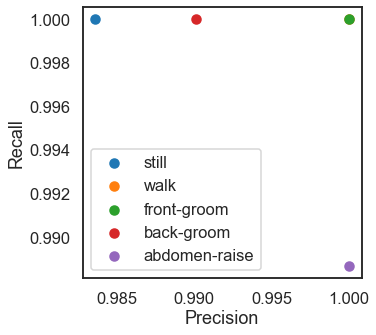

In [8]:
class_names = ['still', 'walk', 'front-groom', 'back-groom', 'abdomen-raise']
n_classes = len(class_names)

# get rid of background class
if len(scores['precision']) != len(class_names):
    precision = scores['precision'][1:]
    recall = scores['recall'][1:]
else:
    precision = scores['precision']
    recall = scores['recall']

# plot precision and recall for each class
plt.figure(figsize=(5, 5))
for n, name in enumerate(class_names):
    plt.scatter(precision[n], recall[n], label=name)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.legend()

plt.show()